In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
%matplotlib inline

try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    os.chdir("/content/gdrive/My Drive/Projects/QuantumFlow/notebooks/recreate")
except:
    pass

if tf.test.gpu_device_name() == '/device:GPU:0':
    print('Found GPU')

import ipywidgets as widgets
from IPython.display import Audio, HTML, display

import sys
sys.path.append('../../')

from quantumflow.calculus_utils import integrate, integrate_simpson, laplace
from quantumflow.numerov_solver import unpack_dataset

Mounted at /content/gdrive


In [11]:
!ls ../../

'data (1)'   LICENSE   notebooks   quantumflow	 README.md


In [12]:
datadir = "../../data"
dataset = "recreate"

N = 1
experiment = "KE_learning"
shuffle_buffer_size = 1000
batch_size = 100
learning_rate = 0.0001


with open(os.path.join(datadir, dataset, 'dataset_training.pkl'), 'rb') as f:
    np_x, np_potentials, np_wavefunctions, np_energies, np_densities, np_kenergies, M, G, h = unpack_dataset(N, pickle.load(f))
    
with open(os.path.join(datadir, dataset, 'dataset_validation.pkl'), 'rb') as f:
    _, np_val_potentials, _, _, np_val_densities, np_val_kenergies, M_val, _, _ = unpack_dataset(N, pickle.load(f))

print("learning_rate:", learning_rate)
print("batch_size:", batch_size)

FileNotFoundError: ignored

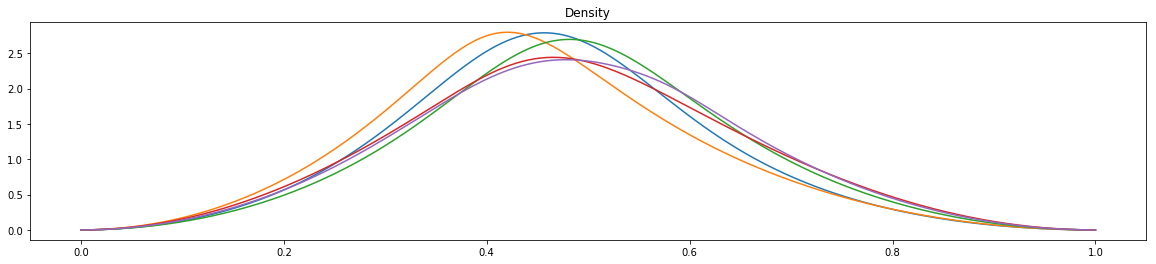

In [0]:
plt.figure(figsize=(20, 4))
for i, np_data in enumerate(np_densities[:5]):
    plt.plot(np_x, np_data, 'C' + str(i%10))
plt.title('Density')
plt.show()

In [0]:
def conv_nn(input, return_layers=False, bias=0.0, filters=(4, 16, 32, 64), kernel_size=(9, 27, 81, 243), padding='same', activation=tf.nn.leaky_relu, **kwargs):
    layers_list = []
    value = tf.expand_dims(input, axis=-1)
    value = tf.expand_dims(value, axis=2)
    layers_list.append(tf.reduce_sum(value, axis=2))
    
    assert len(filters) == len(kernel_size)
    layers = len(filters)
    
    for l in range(layers -1):
        value = tf.layers.conv2d(value, filters=filters[l], kernel_size=(kernel_size[l], 1), activation=activation, padding=padding, **kwargs)
        layers_list.append(tf.reduce_sum(value, axis=2))
        
    value = tf.layers.conv2d(value, filters=filters[-1], kernel_size=(kernel_size[-1], 1), padding=padding, **kwargs)
    value = tf.reduce_sum(value, axis=2)
    layers_list.append(value)
    
    value = tf.reduce_sum(value, axis=2)
    value = tf.reduce_sum(value, axis=1)
    layers_list.append(value)
    
    if return_layers:
        return value, layers_list
    else:
        return value

def conv_deconv_nn(input, return_layers=False, bias=0.0, filters=(4, 16, 32, 64), kernel_size=(9, 27, 81, 243), padding='same', activation=tf.nn.leaky_relu, **kwargs):
    layers_list = []
    value = tf.expand_dims(input, axis=-1)
    value = tf.expand_dims(value, axis=2)
    layers_list.append(tf.reduce_sum(value, axis=2))
    
    assert len(filters) == len(kernel_size)
    layers = len(filters)
    
    for l in range(layers):
        value = tf.layers.conv2d(value, filters=filters[l], kernel_size=(kernel_size[l], 1), activation=activation, padding=padding, **kwargs)
        layers_list.append(tf.reduce_sum(value, axis=2))
        
    for l in reversed(range(1, layers)):
        value = tf.layers.conv2d_transpose(value, filters=filters[l], kernel_size=(kernel_size[l], 1), activation=activation, padding=padding, **kwargs)
        layers_list.append(tf.reduce_sum(value, axis=2))
    
    value = tf.layers.conv2d_transpose(value, filters=1, kernel_size=(kernel_size[0], 1), padding=padding)
    value = tf.reduce_sum(value, axis=2)
    layers_list.append(value)
    
    value = tf.reduce_sum(value, axis=-1)
    
    if return_layers:
        return value, layers_list
    else:
        return value

In [0]:
tf.reset_default_graph()

print('train dataset size:', M)
print('discretization points:', G)
print('discretization width:', h, 'Bohr')

dataset = tf.data.Dataset.from_tensor_slices((np_densities, np_kenergies))

dataset_length = len(np_densities)
print('dataset_length:', dataset_length)

EPOCHS = tf.placeholder(tf.int64)
iter = dataset.shuffle(shuffle_buffer_size).repeat(EPOCHS).batch(batch_size).make_initializable_iterator()
train_density, train_kenergy = iter.get_next()

train_density = tf.identity(train_density, name='density')
train_kenergy = tf.identity(train_kenergy, name='kinetic_energy')

print(train_density)
print(train_kenergy)

val_dataset = tf.data.Dataset.from_tensor_slices((np_val_densities, np_val_kenergies))

val_dataset_length = len(np_val_densities)
print('val_dataset_length:', val_dataset_length)

val_iter = val_dataset.batch(batch_size).make_initializable_iterator()
val_density, val_kenergy = val_iter.get_next()

kwargs = {'filters': (16, 8, 4, 4), 'kernel_size': (121, 121, 121, 121), 'bias': 0.0, 'padding': 'valid', 'activation': tf.nn.softplus}

with tf.variable_scope("model", reuse=False):
    pred_kenergy, layers = conv_nn(train_density, return_layers=True, **kwargs)
    loss = tf.losses.mean_squared_error(pred_kenergy, train_kenergy)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss, global_step=tf.train.create_global_step())

with tf.variable_scope("model", reuse=True):
    DENSITY = tf.placeholder(dtype=tf.float64, shape=train_density.get_shape())
    test_kenergy, layers = conv_nn(DENSITY, return_layers=True, **kwargs)
    test_gradient = tf.gradients(test_kenergy, DENSITY)

with tf.variable_scope("model", reuse=True):
    pred_val_kenergy = conv_nn(val_density, **kwargs)
    val_loss, val_update = tf.metrics.mean_squared_error(pred_val_kenergy, val_kenergy)    

for variable in tf.trainable_variables():
    print(variable.name, variable.get_shape())
print("Free Parameters:", np.sum([np.prod(variable.get_shape()) for variable in tf.trainable_variables()]))

train dataset size: 2000
discretization points: 500
discretization width: 0.002004008016032064 Bohr
dataset_length: 2000
Instructions for updating:
Colocations handled automatically by placer.
Tensor("density:0", shape=(?, 500), dtype=float64)
Tensor("kinetic_energy:0", shape=(?,), dtype=float64)
val_dataset_length: 2000
Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
model/conv2d/kernel:0 (121, 1, 1, 16)
model/conv2d/bias:0 (16,)
model/conv2d_1/kernel:0 (121, 1, 16, 8)
model/conv2d_1/bias:0 (8,)
model/conv2d_2/kernel:0 (121, 1, 8, 4)
model/conv2d_2/bias:0 (4,)
model/conv2d_3/kernel:0 (121, 1, 4, 4)
model/conv2d_3/bias:0 (4,)
Free Parameters: 23264


In [0]:
layers

[<tf.Tensor 'model_1/Sum:0' shape=(?, 500, 1) dtype=float64>,
 <tf.Tensor 'model_1/Sum_1:0' shape=(?, 380, 16) dtype=float64>,
 <tf.Tensor 'model_1/Sum_2:0' shape=(?, 260, 8) dtype=float64>,
 <tf.Tensor 'model_1/Sum_3:0' shape=(?, 140, 4) dtype=float64>,
 <tf.Tensor 'model_1/Sum_4:0' shape=(?, 20, 4) dtype=float64>,
 <tf.Tensor 'model_1/Sum_6:0' shape=(?,) dtype=float64>]

In [0]:
#kwargs = {'filters': (4, 16), 'kernel_size': (9, 81), 'bias': 0.0, 'padding': 'valid', 'activation': tf.nn.softplus}
#
#with tf.variable_scope("model", reuse=False):
#    pred_k_density = conv_deconv_nn(train_density, **kwargs)
#    loss = tf.losses.mean_squared_error(pred_k_density, train_k_density)
#    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
#    train_op = optimizer.minimize(loss, global_step=tf.train.create_global_step())
#
#with tf.variable_scope("model", reuse=True):
#    DENSITY = tf.placeholder(dtype=tf.float32, shape=train_density.get_shape())
#    test_k_density, layers = conv_deconv_nn(DENSITY, return_layers=True, **kwargs)
#    test_k_energy = tf.reduce_mean(test_k_density, axis=1) # not trapezoidal rule but yeah...
#    test_gradient = tf.gradients(test_k_energy, DENSITY)
#
#with tf.variable_scope("model", reuse=True):
#    pred_val_k_density = conv_deconv_nn(val_density, **kwargs)
#    val_loss, val_update = tf.metrics.mean_squared_error(pred_val_k_density, val_k_density)    
#
#for variable in tf.trainable_variables():
#    print(variable.name, variable.get_shape())
#print("Free Parameters:", np.sum([np.prod(variable.get_shape()) for variable in tf.trainable_variables()]))

In [0]:
import ipywidgets as widgets
from IPython.display import Audio, HTML, display, clear_output

In [0]:
loss_ = []
loss_step_ = []
np_test_k_density_ = []
np_layers_ = []

val_loss_ = []
val_loss_step_ = []

sess = tf.Session()
tf.global_variables_initializer().run(session=sess)

saver = tf.train.Saver()

In [0]:
saver.restore(sess, tf.train.latest_checkpoint(experiment))
with open('logging.pkl', 'rb') as f:
    loss_, loss_step_, val_loss_, val_loss_step_, np_test_k_density_, np_layers_ = pickle.load(f)

ValueError: ignored

In [0]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / float(N)

def numpy_ewma_vectorized_v2(data, window):
    data = np.array(data)
    alpha = 2 /(window + 1.0)
    alpha_rev = 1-alpha
    n = data.shape[0]

    pows = alpha_rev**(np.arange(n+1))

    scale_arr = 1/pows[:-1]
    offset = data[0]*pows[1:]
    pw0 = alpha*alpha_rev**(n-1)

    mult = data*pw0*scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums*scale_arr[::-1]
    return out

#plt.figure(figsize=(20, 8))
#plt.plot(loss_step_, np.log(loss_))
#plt.plot(val_loss_step_, np.log(val_loss_))
#plt.plot(numpy_ewma_vectorized_v2(loss_, 1))
#plt.ylim([0, 0.01])
#plt.show()

In [0]:
def save_model():
    save_path = saver.save(sess, os.path.join(datadir, experiment, "model.ckpt"), global_step=sess.run(tf.train.get_global_step()))
    print("Model saved in path: %s" % save_path)
    
    with open(os.path.join(datadir, experiment, 'logging.pkl'), 'wb') as f:
        pickle.dump([loss_, loss_step_, val_loss_, val_loss_step_, np_test_k_density_, np_layers_], f)

def train(epochs, val_interval, save_interval, progress=None, val_progress=None):
    try:
        sess.run(iter.initializer, feed_dict={EPOCHS: epochs})
        if progress is not None:
            progress.max = sess.run(tf.train.get_global_step()) + (dataset_length*epochs)//batch_size
        while True:
            loss_.append(sess.run([loss, train_op])[0])
            global_step = sess.run(tf.train.get_global_step())
            loss_step_.append(global_step)
            
            if progress is not None:
                progress.value = global_step
                progress.description = str(progress.value) + '/' + str(progress.max)

            np_test_k_density, np_layers = sess.run([test_kenergy, layers], 
                                                    feed_dict={DENSITY: np.expand_dims(np_densities[61], axis=0)})

            np_test_k_density_.append(np_test_k_density)
            np_layers_.append(np_layers)

            if global_step % val_interval == 0:
                sess.run(val_iter.initializer)
                sess.run(tf.local_variables_initializer())
                if val_progress is not None:
                    val_progress.max = val_dataset_length
                    val_progress.value = 0
                try:
                    while True:
                        sess.run(val_update)
                        if val_progress is not None:
                            val_progress.value += batch_size
                            val_progress.description = str(val_progress.value) + '/' + str(val_progress.max)

                except tf.errors.OutOfRangeError:
                    np_val_loss = sess.run(val_loss)
                    val_loss_.append(np_val_loss)
                    val_loss_step_.append(global_step)
                    
                    #plt.figure(figsize=(20, 8))
                    #plt.plot(loss_step_, np.log(loss_))
                    #plt.plot(val_loss_step_, np.log(val_loss_))
                    #clear_output(wait=True)
                    #display(plt.gcf())

            if global_step % save_interval == 0:
                save_model()

    except tf.errors.OutOfRangeError:
        display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))
        save_model()

In [0]:
progress = widgets.IntProgress(value=0, max=0, description='Training:', 
                               bar_style='info', layout=widgets.Layout(width='92%'))
display(progress)

val_progress = widgets.IntProgress(value=0, max=0, description='Validation:', 
                                   bar_style='success', layout=widgets.Layout(width='92%'))
display(val_progress)

IntProgress(value=0, bar_style='info', description='Training:', layout=Layout(width='92%'), max=0)

IntProgress(value=0, bar_style='success', description='Validation:', layout=Layout(width='92%'), max=0)

In [0]:
epochs = 500
val_interval = 100
save_interval = 1000
train(epochs, val_interval, save_interval, progress=progress, val_progress=val_progress)

Model saved in path: ../../data/KE_learning/model.ckpt-1000
Model saved in path: ../../data/KE_learning/model.ckpt-2000
Model saved in path: ../../data/KE_learning/model.ckpt-3000
Model saved in path: ../../data/KE_learning/model.ckpt-4000
Model saved in path: ../../data/KE_learning/model.ckpt-5000
Instructions for updating:
Use standard file APIs to delete files with this prefix.
Model saved in path: ../../data/KE_learning/model.ckpt-6000
Model saved in path: ../../data/KE_learning/model.ckpt-7000
Model saved in path: ../../data/KE_learning/model.ckpt-8000
Model saved in path: ../../data/KE_learning/model.ckpt-9000
Model saved in path: ../../data/KE_learning/model.ckpt-10000


Model saved in path: ../../data/KE_learning/model.ckpt-10000


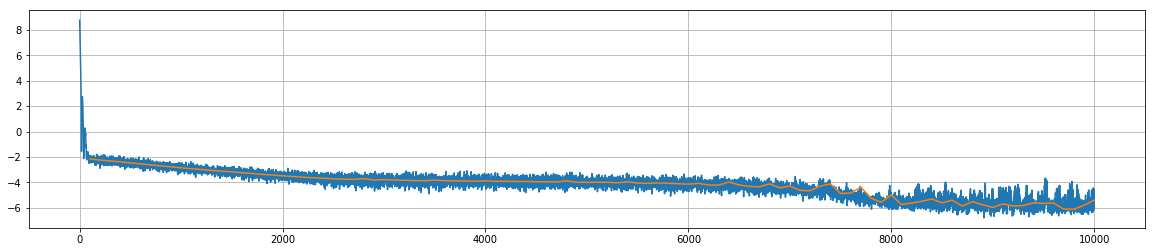

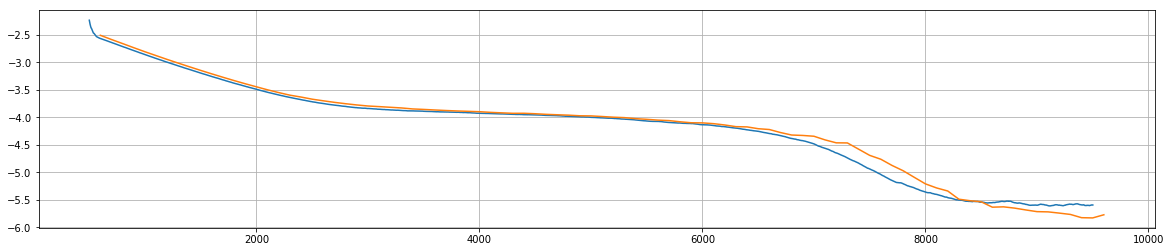

In [0]:
plt.figure(figsize=(20, 4))
plt.plot(loss_step_, np.log(loss_))
plt.plot(val_loss_step_, np.log(val_loss_))
plt.grid(True)
plt.show()

plt.figure(figsize=(20, 4))
plt.plot(loss_step_[500:-499], running_mean(np.log(loss_), 1000))
plt.plot(val_loss_step_[5:-4], running_mean(np.log(val_loss_), 10))
plt.grid(True)
plt.show()

Energy prediction:
5.154162081323369 5.222314370633655


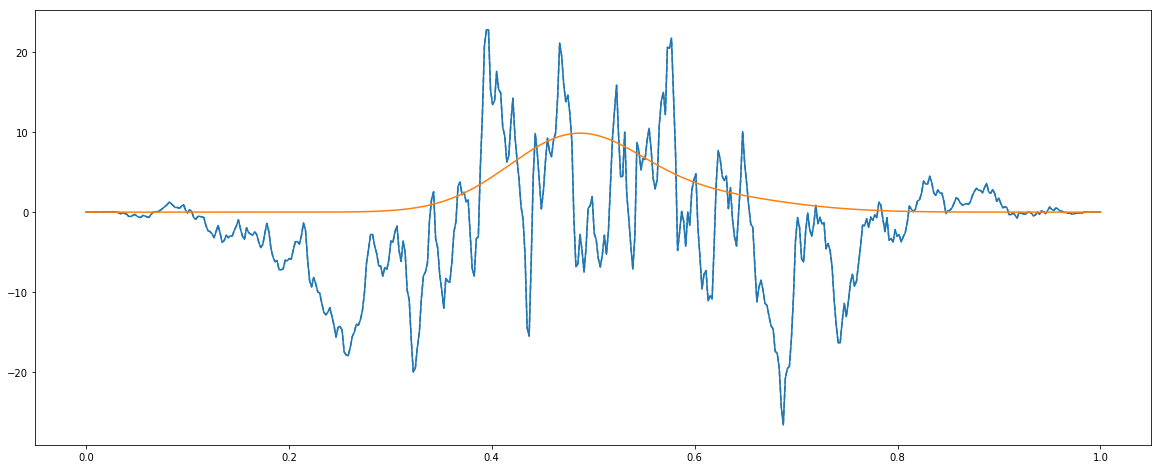

In [0]:
from matplotlib import animation, rc
plt.rcParams['svg.fonttype'] = 'none'

def anim_plot(array, x=None, interval=100, bar="", figsize=(10, 4), **kwargs):
    frames = len(array)
    
    if not bar == "":
        import ipywidgets as widgets
        widget = widgets.IntProgress(min=0, max=frames, description=bar, bar_style='success',
                                     layout=widgets.Layout(width='92%'))
        display(widget)

    fig, ax = plt.subplots(figsize=figsize)
    
    if x is None:
        plt_h = ax.plot(array[0], **kwargs)
    else:
        plt_h = ax.plot(x, array[0], **kwargs) 
        
    ax.set_ylim([np.min(array), np.max(array)])

    def init():
        return plt_h

    def animate(f):
        if not bar == "":
            widget.value = f

        for i, h in enumerate(plt_h):
            if x is None:
                h.set_data(np.arange(len(array[f][:, i])), array[f][:, i], **kwargs)
            else:
                h.set_data(x, array[f][:, i], **kwargs)
        return plt_h

    # call the animator. blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=frames, interval=interval,
                                   blit=True, repeat=False)

    plt.close(fig)
    rc('animation', html='html5')
    display(HTML(anim.to_html5_video(embed_limit=1024)))

    if not bar == "":
        widget.close()



np_test_K, np_test_gradient = sess.run([test_kenergy, test_gradient[0]], 
                                                feed_dict={DENSITY: np.expand_dims(np_densities[61], axis=0)})
        
    
print('Energy prediction:')
print(np_kenergies[61], np_test_K[0])

plt.figure(figsize=(20, 8))
plt.plot(np_x, np_test_gradient[0]/h)
plt.plot(np_x, -np_test_gradient[0]/h, 'C0', linestyle='--')
#plt.plot(np_x, np_density[61])
plt.plot(np_x, np_potentials[61])
plt.show()

In [0]:
for l in reversed(range(1, len(np_layers_[0])-1)):
    anim_plot([np_layers_[i][l][0, :, :] for i in range(0, len(np_layers_), 100)], bar="Animation:", interval=10)

IntProgress(value=0, bar_style='success', description='Animation:', layout=Layout(width='92%'))

IntProgress(value=0, bar_style='success', description='Animation:', layout=Layout(width='92%'))

IntProgress(value=0, bar_style='success', description='Animation:', layout=Layout(width='92%'))

IntProgress(value=0, bar_style='success', description='Animation:', layout=Layout(width='92%'))